In [47]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

from skimage.morphology import closing, square
from tools import *
from plot import *
from preprocessing import RX_anomaly_detector

# Loading data & Pre-processing

Loading Indiana and Salinas images and their ground truth

In [24]:
indiana_img = np.load('../data/indianapines.npy')
indiana_labels = np.load('../data/indianapines_gt.npy')
salinas_img = np.load('../data/salinas.npy')
salinas_labels = np.load('../data/salinas_gt.npy')

In [25]:
# normalize radiance values to get reflectance values
indiana_img = indiana_img / indiana_img.max()
salinas_img = salinas_img / salinas_img.max()

In [26]:
print("Indiana shape: {}".format(indiana_img.shape))
print("Salinas shape: {}".format(salinas_img.shape))

Indiana shape: (145, 145, 200)
Salinas shape: (512, 217, 204)


In [27]:
# Reshaping the HSI as a 2D matrix
X_indiana = indiana_img.reshape((-1, indiana_img.shape[-1]))
print("Indiana shape: {}".format(X_indiana.shape))

X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1]))
print("Salinas shape: {}".format(X_salinas.shape))

Indiana shape: (21025, 200)
Salinas shape: (111104, 204)


In [28]:
n_cluster_indiana = len(np.unique(indiana_labels)) - 1
n_cluster_salinas = len(np.unique(salinas_labels)) - 1

In [29]:
print("Number of labels Indiana: {}".format(n_cluster_indiana))
print("Number of labels Salinas: {}".format(n_cluster_salinas))

Number of labels Indiana: 16
Number of labels Salinas: 16


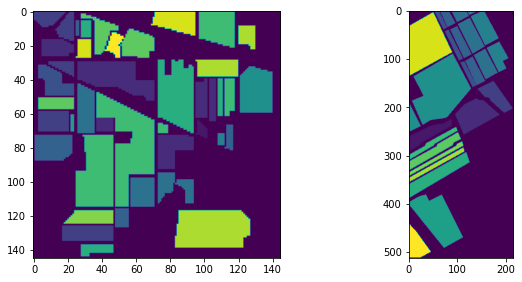

In [30]:
plot_two_figures(indiana_labels, salinas_labels)

 ## PCA

In [31]:
n_components_indiana = get_number_components(X_indiana)
n_components_salinas = get_number_components(X_salinas)

Fitting the PCA
Fitting the PCA


In [32]:
print("Number of components Indiana: {}".format(n_components_indiana))
print("Number of components Salinas: {}".format(n_components_salinas))

Number of components Indiana: 69
Number of components Salinas: 6


In [33]:
X_indiana_reduced = extract_features(X_indiana, n_components_indiana)
X_salinas_reduced = extract_features(X_salinas, n_components_salinas)

In [34]:
print("Indiana reduced data shape: {}".format(X_indiana_reduced.shape))
print("Salinas reduced data shape: {}".format(X_salinas_reduced.shape))

Indiana reduced data shape: (21025, 69)
Salinas reduced data shape: (111104, 6)


## RX anomaly detector

In [61]:
X_indiana_reduced_img = X_indiana_reduced.reshape((indiana_img.shape[0], indiana_img.shape[1], X_indiana_reduced.shape[1]))
X_salinas_reduced_img = X_salinas_reduced.reshape((salinas_img.shape[0], salinas_img.shape[1], X_salinas_reduced.shape[1]))

In [62]:
indiana_anomalies = RX_anomaly_detector(X_indiana_reduced_img)
salinas_anomalies = RX_anomaly_detector(X_salinas_reduced_img)

In [64]:
outlier_indiana_pos = np.argwhere(indiana_anomalies == True).tolist()
outlier_salinas_pos = np.argwhere(salinas_anomalies == True).tolist()

In [65]:
X_salinas_no_outlier, X_salinas_outlier_positions = copy_without_outlier(X_salinas_reduced_img, outlier_salinas_pos)
X_indiana_no_outlier, X_indiana_outlier_positions = copy_without_outlier(X_indiana_reduced_img, outlier_indiana_pos)

# Gaussian Mixture

### Salinas image with outliers

In [66]:
salinas_model = GaussianMixture(n_components=n_cluster_salinas, verbose=1)

In [67]:
salinas_model.fit(X_salinas_reduced)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True


GaussianMixture(n_components=16, verbose=1)

In [70]:
salinas_preds = salinas_model.predict(X_salinas_reduced)
salinas_preds = salinas_preds.reshape((salinas_img.shape[0], salinas_img.shape[1]))

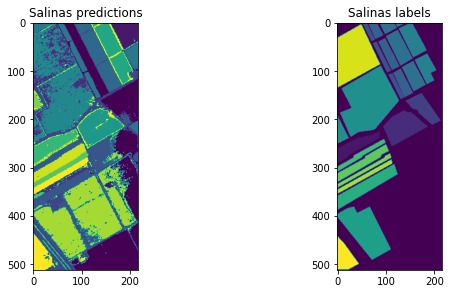

In [74]:
plot_two_figures(salinas_preds, salinas_labels, 'Salinas predictions', 'Salinas labels')

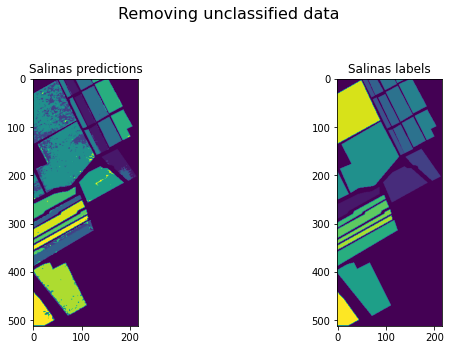

In [76]:
salinas_preds_corrected = remove_unclassified(salinas_preds, salinas_labels)
plot_two_figures(salinas_preds_corrected, salinas_labels, 'Salinas predictions', 'Salinas labels', suptitle='Removing unclassified data')

In [77]:
salinas_labels_cpy, salinas_final_preds = compute_labels_correspondence(salinas_labels, salinas_preds_corrected, n_cluster_salinas)

In [35]:
def apply_rx_anomaly_detector(X_test):
    c = np.cov(X_test.T)
    inv_c = np.linalg.inv(c)

    res = np.empty((X_test.shape))

    for i in range(res.shape[0]):
        res[i] = X_test[i] @ inv_c @ X_test[i]
    
    return np.abs(res)

In [36]:
print(X_indiana_reduced.shape)

(21025, 69)


In [37]:
indiana_anomaly = apply_rx_anomaly_detector(X_indiana_reduced)
salinas_anomaly = apply_rx_anomaly_detector(X_salinas_reduced)

In [38]:
print(indiana_anomaly.shape)

(21025, 69)


In [44]:
X_indiana_reduced_img = X_indiana_reduced.reshape((indiana_img.shape[0], indiana_img.shape[1], X_indiana_reduced.shape[1]))

In [45]:
X_indiana_reduced_img.shape

(145, 145, 69)

In [48]:
indiana_anomalies_res = RX_anomaly_detector(X_indiana_reduced_img)

In [52]:
X_indiana_reduced_img.shape

(145, 145, 69)

In [53]:
indiana_anomalies_res.shape

(145, 145)

In [49]:
indiana_anomalies_res_band = indiana_anomalies_res > 175

In [51]:
indiana_anomalies_res_band.shape

(145, 145)

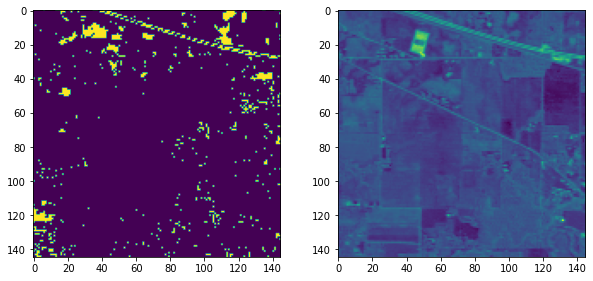

In [57]:
plot_two_figures(indiana_anomalies_res_band[:, :], X_indiana_reduced_img[:, :, 2])

In [58]:
salinas_anomaly = salinas_anomaly.reshape((salinas_img.shape[0], salinas_img.shape[1], X_salinas_reduced.shape[1]))
X_salinas_reduced_img = X_salinas_reduced.reshape((salinas_img.shape[0], salinas_img.shape[1], X_salinas_reduced.shape[1]))

indiana_anomaly = indiana_anomaly.reshape((indiana_img.shape[0], indiana_img.shape[1], X_indiana_reduced.shape[1]))
X_indiana_reduced_img = X_indiana_reduced.reshape((indiana_img.shape[0], indiana_img.shape[1], X_indiana_reduced.shape[1]))

In [59]:
print(indiana_anomaly.shape)
print(X_indiana_reduced_img.shape)

(145, 145, 69)
(145, 145, 69)


In [15]:
salinas_anomalies_res = salinas_anomaly[:, :] > 50
indiana_anomalies_res = indiana_anomaly[:, :] > 175

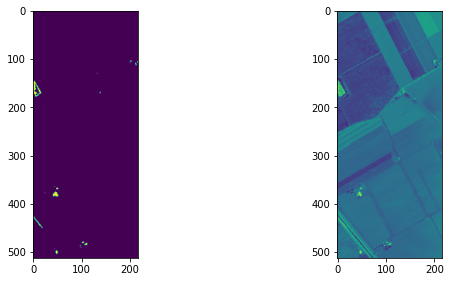

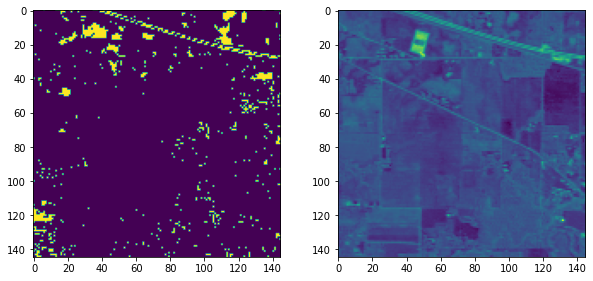

In [16]:
plot_two_figures(salinas_anomalies_res[:, :, 2], X_salinas_reduced_img[:, :, 2])
plot_two_figures(indiana_anomalies_res[:, :, 2], X_indiana_reduced_img[:, :, 2])

In [17]:
outlier_salinas_pos = np.argwhere(salinas_anomalies_res == True).tolist()
outlier_indiana_pos = np.argwhere(indiana_anomalies_res == True).tolist()

In [ ]:
X_salinas_no_outlier, X_salinas_outlier_positions = copy_without_outlier(X_salinas_reduced_img, outlier_salinas_pos)
X_indiana_no_outlier, X_indiana_outlier_positions = copy_without_outlier(X_indiana_reduced_img, outlier_indiana_pos)

In [ ]:
print(X_salinas_no_outlier.shape)
print(X_salinas_reduced_img.shape)
print(len(outlier_salinas_pos))

## GMM on Salinas with outliers

In [ ]:
salinas_model = GaussianMixture(n_components=n_cluster_salinas, verbose=1)

In [ ]:
salinas_model.fit(X_salinas_reduced)

In [ ]:
salinas_preds = salinas_model.predict(X_salinas_reduced)

In [ ]:
salinas_preds = salinas_preds.reshape((salinas_img.shape[0], salinas_img.shape[1]))

In [ ]:
salinas_preds_corrected = remove_unclassified(salinas_preds, salinas_labels)
plot_two_figures(salinas_labels, salinas_preds_corrected)

In [ ]:
salinas_labels_cpy, salinas_final_preds = compute_labels_correspondence(salinas_labels, salinas_preds_corrected, n_cluster_salinas)

In [ ]:
plot_two_figures(salinas_labels_cpy, salinas_final_preds)

In [ ]:
def calculate_adjusted_rand_score(labels, preds):
    salinas_labels_flatten = labels.flatten()
    final_preds_flatten = preds.flatten()

    test = salinas_labels_flatten[~(salinas_labels_flatten==0)]
    test2 = final_preds_flatten[~(final_preds_flatten==0)]

    return adjusted_rand_score(test, test2)

In [ ]:
calculate_adjusted_rand_score(salinas_labels, salinas_final_preds)

## GMM on Salinas without outliers

In [ ]:
salinas_model = GaussianMixture(n_components=n_cluster_salinas, verbose=1)

In [ ]:
salinas_model.fit(X_salinas_no_outlier)

In [ ]:
salinas_preds = salinas_model.predict(X_salinas_no_outlier)

In [ ]:
salinas_preds_outliers = rebuild_data_with_outliers(salinas_preds, X_salinas_outlier_positions, outlier_salinas_pos, (salinas_img.shape[0], salinas_img.shape[1]))

In [ ]:
salinas_preds_corrected = remove_unclassified(salinas_preds_outliers, salinas_labels)
plot_two_figures(salinas_preds_outliers, salinas_preds_corrected)

In [ ]:
salinas_labels_cpy, salinas_final_preds = compute_labels_correspondence(salinas_labels, salinas_preds_corrected, n_cluster_salinas)

In [37]:
#for i in range(20):
#    print(i, salinas_labels_cpy[salinas_labels_cpy == i].size, salinas_final_preds[salinas_final_preds == i].size)

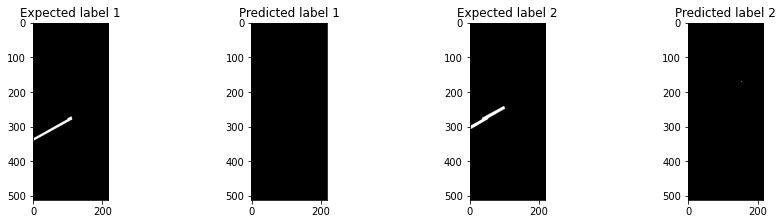

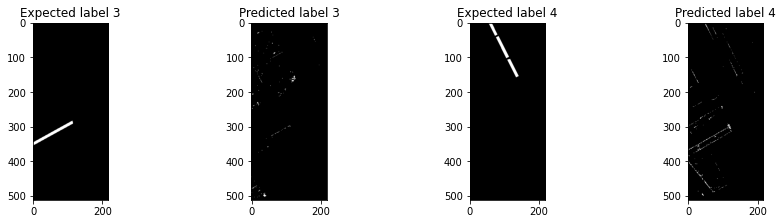

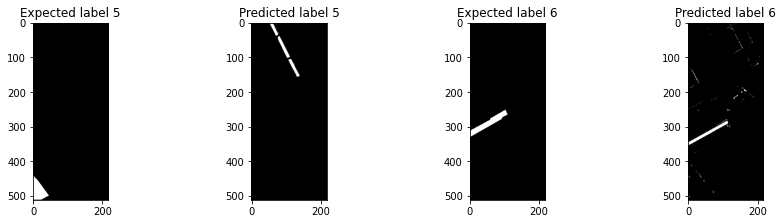

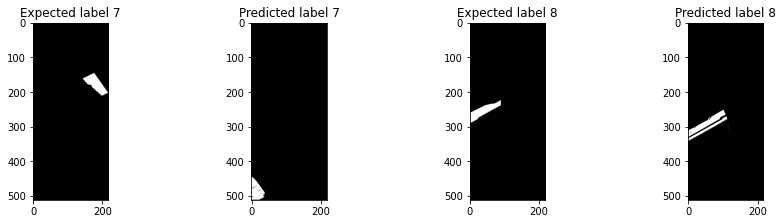

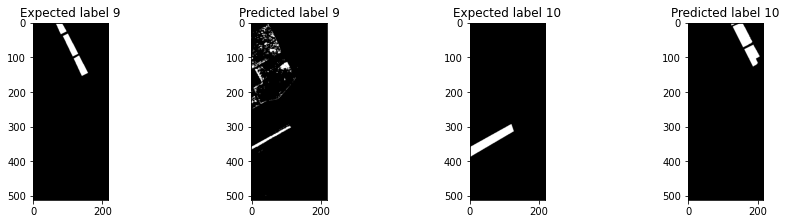

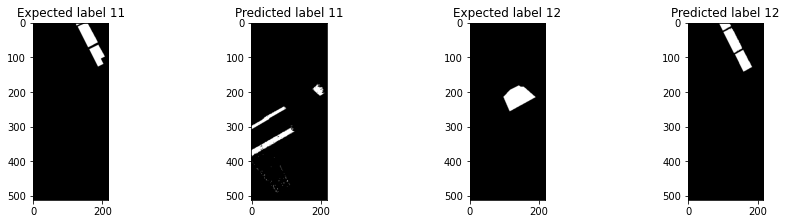

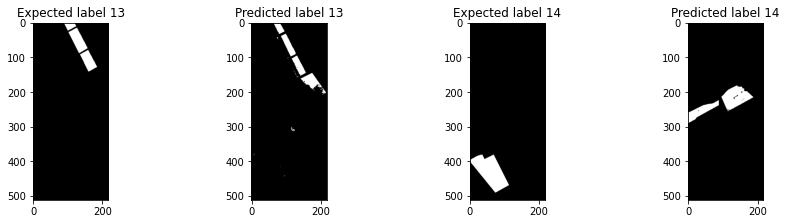

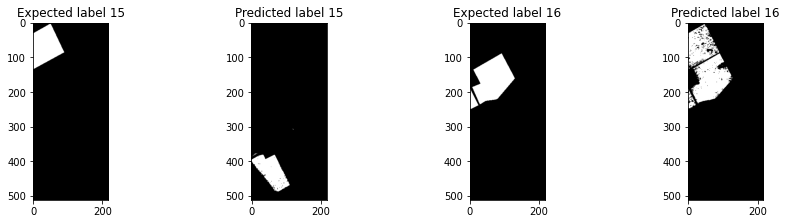

In [38]:
plot_each_labels(salinas_labels_cpy, salinas_final_preds, n_cluster_salinas, figsize=(15, 15), cmap='gray')

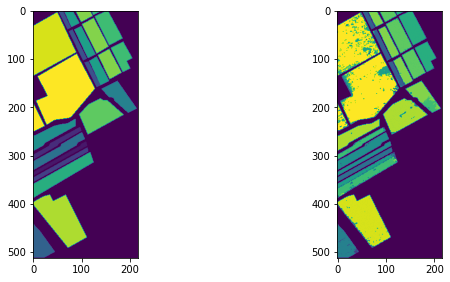

In [39]:
plot_two_figures(salinas_labels_cpy, salinas_final_preds)

In [40]:
calculate_adjusted_rand_score(salinas_labels, salinas_final_preds)

0.644064542618418

## GMM on Indiana with outliers

In [41]:
indiana_model = GaussianMixture(n_components=n_cluster_indiana, verbose=1)

In [42]:
indiana_model.fit(X_indiana_reduced)

Initialization 0
  Iteration 10
Initialization converged: True


GaussianMixture(n_components=16, verbose=1)

In [43]:
indiana_preds = indiana_model.predict(X_indiana_reduced)
indiana_preds = indiana_preds.reshape((indiana_img.shape[0], indiana_img.shape[1]))

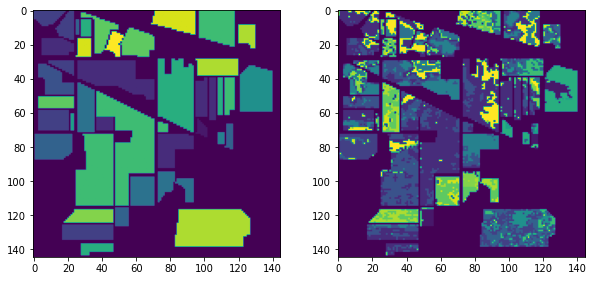

In [44]:
indiana_preds_corrected = remove_unclassified(indiana_preds, indiana_labels)
plot_two_figures(indiana_labels, indiana_preds_corrected)

In [45]:
indiana_labels_cpy, indiana_final_preds = compute_labels_correspondence(indiana_labels, indiana_preds_corrected, n_cluster_indiana)

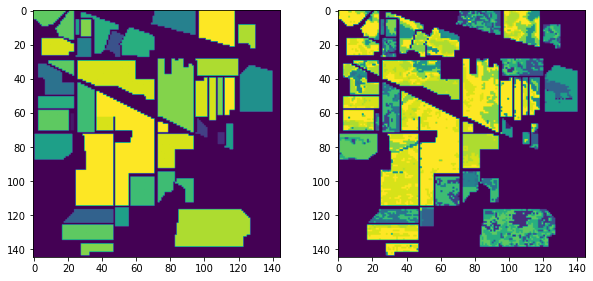

In [46]:
plot_two_figures(indiana_labels_cpy, indiana_final_preds)

In [47]:
for i in range(20):
    print(i, indiana_labels_cpy[indiana_labels_cpy == i].size, indiana_final_preds[indiana_final_preds == i].size)

0 10776 10776
1 20 35
2 28 166
3 46 210
4 93 245
5 205 263
6 237 302
7 386 308
8 478 321
9 483 461
10 593 581
11 730 601
12 830 677
13 972 751
14 1265 813
15 1428 1606
16 2455 2909
17 0 0
18 0 0
19 0 0


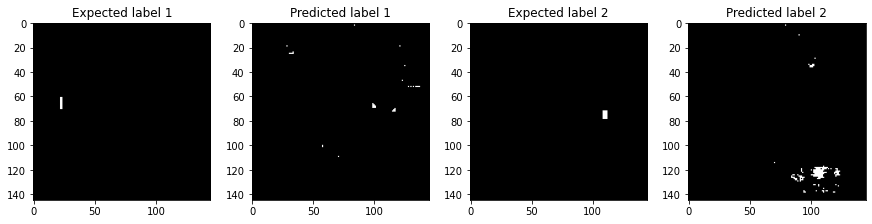

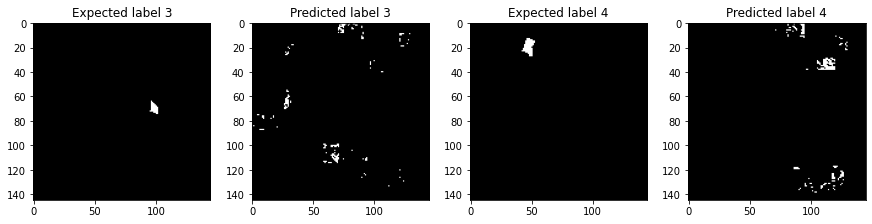

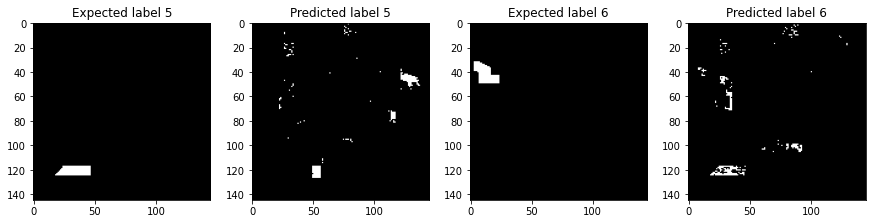

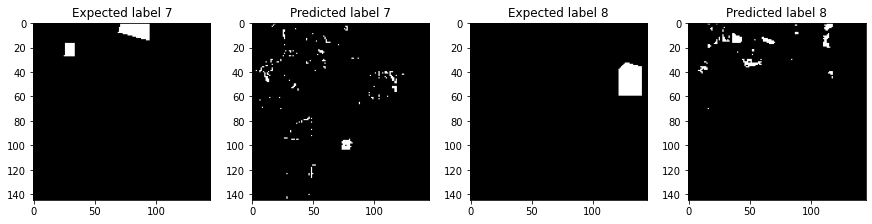

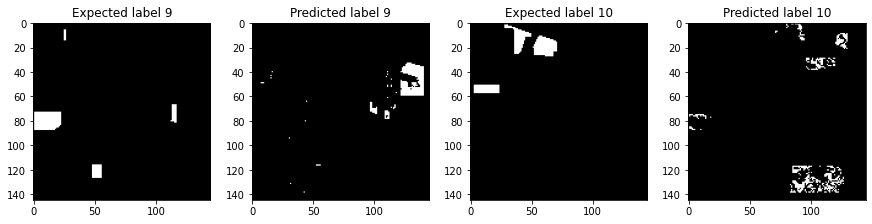

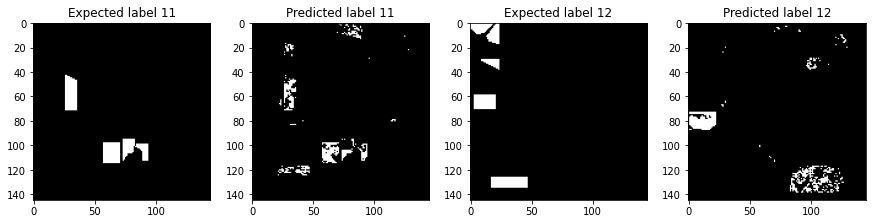

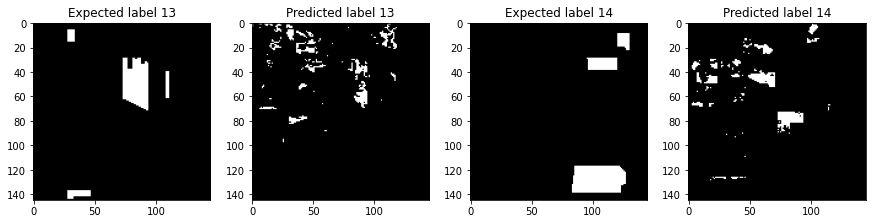

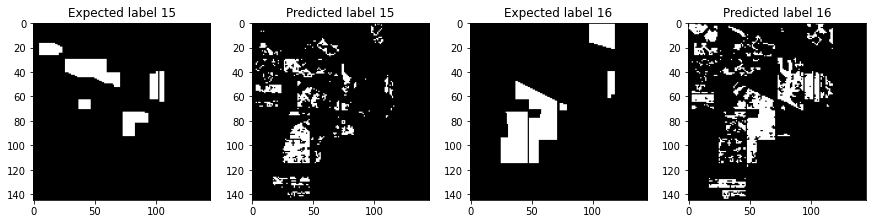

In [48]:
plot_each_labels(indiana_labels_cpy, indiana_final_preds, n_cluster_indiana, figsize=(15, 15), cmap='gray')

In [49]:
calculate_adjusted_rand_score(indiana_labels, indiana_final_preds)

0.2237040247459035

## GMM on Indiana without outliers

In [50]:
indiana_model = GaussianMixture(n_components=n_cluster_indiana, verbose=1)

In [51]:
indiana_model.fit(X_indiana_no_outlier)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True


GaussianMixture(n_components=16, verbose=1)

In [52]:
indiana_preds = indiana_model.predict(X_indiana_no_outlier)

In [53]:
indiana_preds_outliers = rebuild_data_with_outliers(indiana_preds, X_indiana_outlier_positions, outlier_indiana_pos, (indiana_img.shape[0], indiana_img.shape[1]))

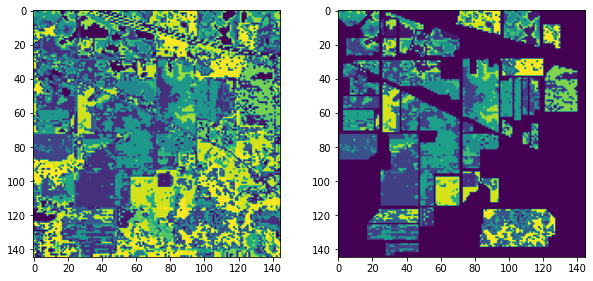

In [54]:
indiana_preds_corrected = remove_unclassified(indiana_preds_outliers, indiana_labels)
plot_two_figures(indiana_preds_outliers, indiana_preds_corrected)

In [55]:
indiana_labels_cpy, indiana_final_preds = compute_labels_correspondence(indiana_labels, indiana_preds_corrected, n_cluster_indiana)

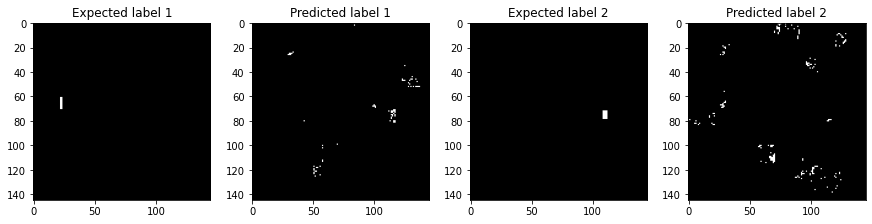

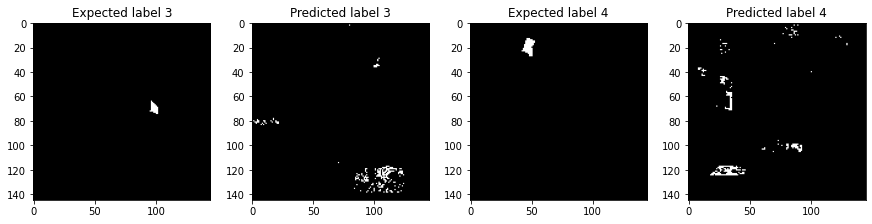

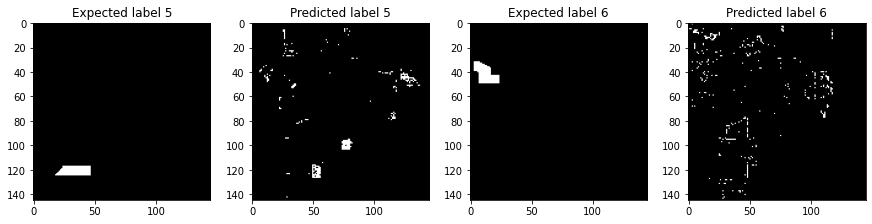

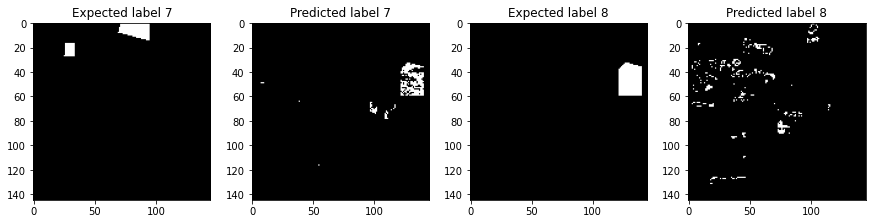

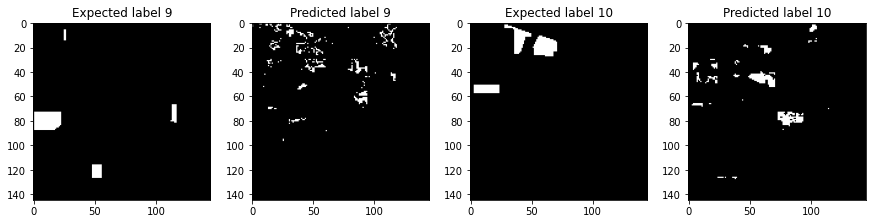

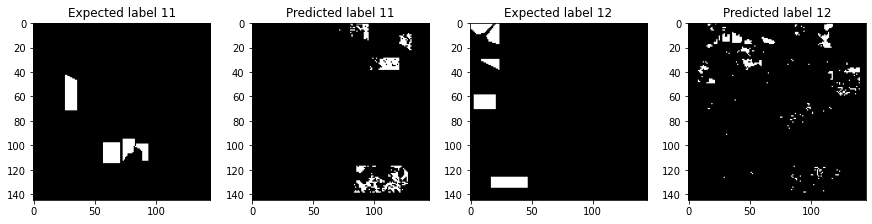

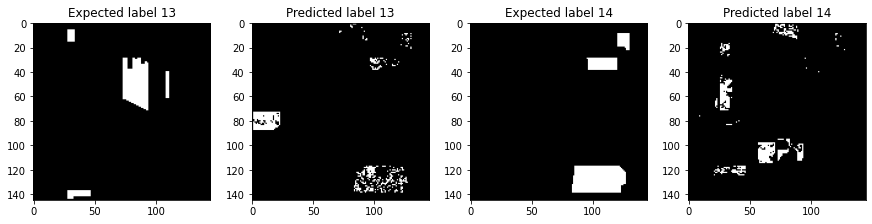

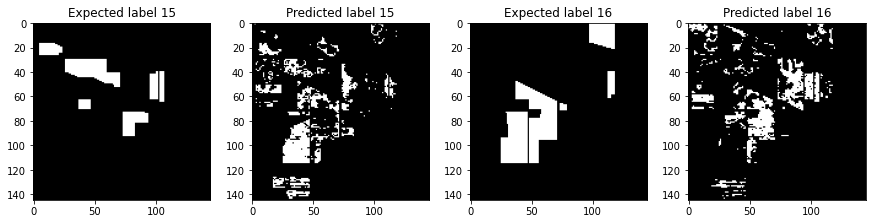

In [56]:
plot_each_labels(indiana_labels_cpy, indiana_final_preds, n_cluster_indiana, figsize=(15, 15), cmap='gray')

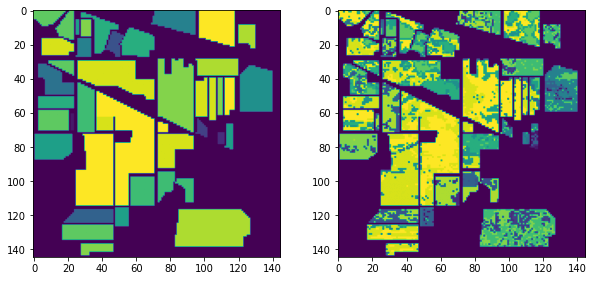

In [57]:
plot_two_figures(indiana_labels_cpy, indiana_final_preds)

In [58]:
calculate_adjusted_rand_score(indiana_labels, indiana_final_preds)

0.2217628822557382

## GMM

In [89]:
n_cluster_indiana = len(np.unique(indiana_labels)) - 1
n_cluster_salinas = len(np.unique(salinas_labels)) - 1

In [90]:
print("Number of labels Indiana: {}".format(n_cluster_indiana))
print("Number of labels Salinas: {}".format(n_cluster_salinas))

Number of labels Indiana: 16
Number of labels Salinas: 16


In [91]:
indiana_model = GaussianMixture(n_components=n_cluster_indiana, verbose=1)
salinas_model = GaussianMixture(n_components=n_cluster_salinas, verbose=1)

In [92]:
indiana_model.fit(X_indiana_reduced)

Initialization 0
  Iteration 10
Initialization converged: True


GaussianMixture(n_components=16, verbose=1)

In [93]:
salinas_model.fit(X_salinas_reduced)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True


GaussianMixture(n_components=16, verbose=1)

In [94]:
indiana_preds = indiana_model.predict(X_indiana_reduced)
salinas_preds = salinas_model.predict(X_salinas_reduced)

In [95]:
indiana_preds = indiana_preds.reshape((indiana_img.shape[0], indiana_img.shape[1]))
salinas_preds = salinas_preds.reshape((salinas_img.shape[0], salinas_img.shape[1]))

In [96]:
# apply morphologie
#closing_indiana_preds = closing(indiana_preds, square(3))
#closing_salinas_preds = closing(salinas_preds, square(3))

In [97]:
#final_indiana_preds = remove_unclassified(closing_indiana_preds, indiana_labels)
#final_salinas_preds = remove_unclassified(closing_salinas_preds, salinas_labels)
final_indiana_preds = remove_unclassified(indiana_preds, indiana_labels)
final_salinas_preds = remove_unclassified(salinas_preds, salinas_labels)

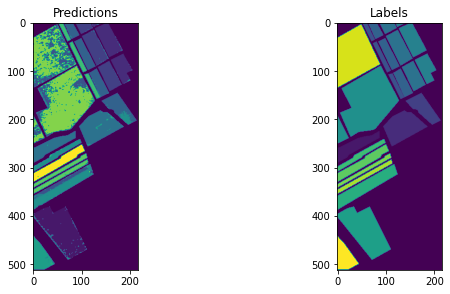

In [98]:
plot_two_figures(final_salinas_preds, salinas_labels, 'Predictions', 'Labels')

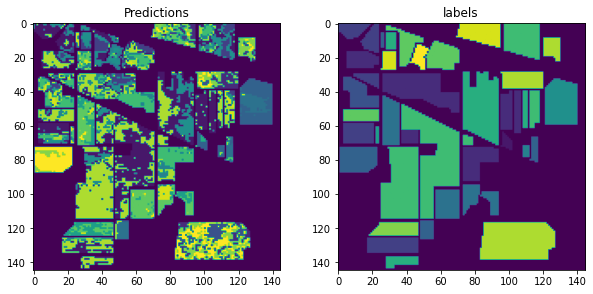

In [99]:
plot_two_figures(final_indiana_preds, indiana_labels, 'Predictions', 'labels')

In [100]:
salinas_labels_flatten = salinas_labels.flatten()
final_preds_flatten = final_salinas_preds.flatten()

test = salinas_labels_flatten[~(salinas_labels_flatten==0)]
test2 = final_preds_flatten[~(final_preds_flatten==0)]

adjusted_rand_score(test, test2)

0.6295984206168691

In [101]:
indiana_labels_flatten = indiana_labels.flatten()
final_preds_flatten = final_indiana_preds.flatten()

test = indiana_labels_flatten[~(indiana_labels_flatten==0)]
test2 = final_preds_flatten[~(final_preds_flatten==0)]

adjusted_rand_score(test, test2)

0.22223925700810218